# Chapter 21: Insights into Actions

For additional context see chapter 21 of [The Virus of Variation](https://www.brokenquality.com/book). Questions? Email James.Lehner@gmail.com or QualityIsBroken@gmail.com.

In [1]:
# Import libraries
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import seaborn as sns
import pandas as pd

%matplotlib inline

## Helper function for process statistics

In [2]:
def calc_process_stats(df, value_col, mr_col, round_value=2,
                        E2=2.660, D4=3.268, print_results=False):
    """
    Calculate process limits and return them as a dictionary.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the data.
    value_col : str
        Column name for the individual values (e.g., 'Rate').
    mr_col : str
        Column name for the moving ranges (e.g., 'Moving Range').
    round_value : int
        Number of decimal places to round to.
    E2 : float
        Constant for calculating X chart limits.
    D4 : float
        Constant for calculating mR chart limits.
    print_results : str
        Print results for calculated statistics.

    Returns
    -------
    dict
        Dictionary with mean, average moving range, and process limits.
    """

    ave_mR = round(df[mr_col].mean(), round_value)
    mean = round(df[value_col].mean(), round_value)

    UPL = round(mean + (E2 * ave_mR), round_value)
    calc_LPL = round(mean - (E2 * ave_mR), round_value)
    LPL = max(0, calc_LPL)  # ensure LPL is not negative
    URL = round(D4 * ave_mR, round_value)
    
    results = {
        "Mean": mean,
        "Average mR": ave_mR,
        "UPL": UPL,
        "Calculated LPL": calc_LPL,
        "LPL": LPL,
        "URL": URL
    }
    
    if print_results == True:
        # Print results
        print("Process Statistics:")
        for key, value in results.items():
            print(f"  {key}: {value}")

    return results

## Get the data

In [3]:
# Get data function
def get_data(dataset_url) -> pd.DataFrame:
    return pd.read_csv(dataset_url)

In [7]:
# Death-to-birth rate dataset url
rate_url = r'https://raw.githubusercontent.com/jimlehner/the-virus-of-variation/refs/heads/main/data/software-verification-death-to-birth-rates.csv'

# Get data
rate_df = get_data(rate_url)

# Make 'Year' column dtype string
rate_df = rate_df.astype({'Sample':'string','Year':'string'})

rate_df = rate_df.rename(columns={'Moving Ranges':'Moving Range'})

# Show dataframe
rate_df.head(10)

,Sample,Hospital,Year,Rate,Moving Range
0,1,Vienna General Hospital,1810,0.8,NaN
1,2,Vienna General Hospital,1811,1.9,1.1
2,3,Vienna General Hospital,1812,0.6,1.3
3,4,Vienna General Hospital,1813,1.1,0.5
4,5,Vienna General Hospital,1814,3.2,2.1
5,6,Vienna General Hospital,1815,0.7,2.5
6,7,Vienna General Hospital,1816,0.5,0.2
7,8,Vienna General Hospital,1817,0.9,0.4
8,9,Vienna General Hospital,1818,2.2,1.3
9,10,Vienna General Hospital,1819,5.0,2.8


## Figure 21.1: XmR chart of verification dataset

In [8]:
# Calculate before pathological anatomy process statistics
verification_stats = calc_process_stats(rate_df, 'Rate', 'Moving Range')

# Show results
verification_stats

{'Mean': 2.69,
 'Average mR': 1.97,
 'UPL': 7.93,
 'Calculated LPL': -2.55,
 'LPL': 0,
 'URL': 6.44}

In [15]:
# Specify round_value
round_value = 2
tickinterval = 2

# Specify stats to use
stats = verification_stats

# Prepare data for plotting
data = rate_df["Rate"]
moving_range = round(abs(data.diff()),round_value)
labels = rate_df["Year"]

# --- Masking parameters ---
upper_lim = np.ma.masked_where(data < stats['UPL'], data)
lower_lim = np.ma.masked_where(data > stats['LPL'], data)

url_greater = np.ma.masked_where(moving_range <= stats['URL'], moving_range)

# --- Line styles and colors ---
x_limits = ['Mean', 'UPL', 'LPL']
mr_limits = ['Average mR', 'URL']

# Map each limit to its linestyle/color
line_styles = {
    'Mean': ('-', 'black'),
    'Average mR': ('-', 'black'),
    'UPL': ('--', 'red'),
    'LPL': ('--', 'red'),
    'URL': ('--', 'red')
}

# --- Create lines and labels dynamically ---
xchart_lines  = [(stats[k], *line_styles[k]) for k in x_limits]
mrchart_lines = [(stats[k], *line_styles[k]) for k in mr_limits]

xchart_labels = [(stats[k], stats[k]) for k in x_limits]
mrchart_labels = [(stats[k], stats[k]) for k in mr_limits]

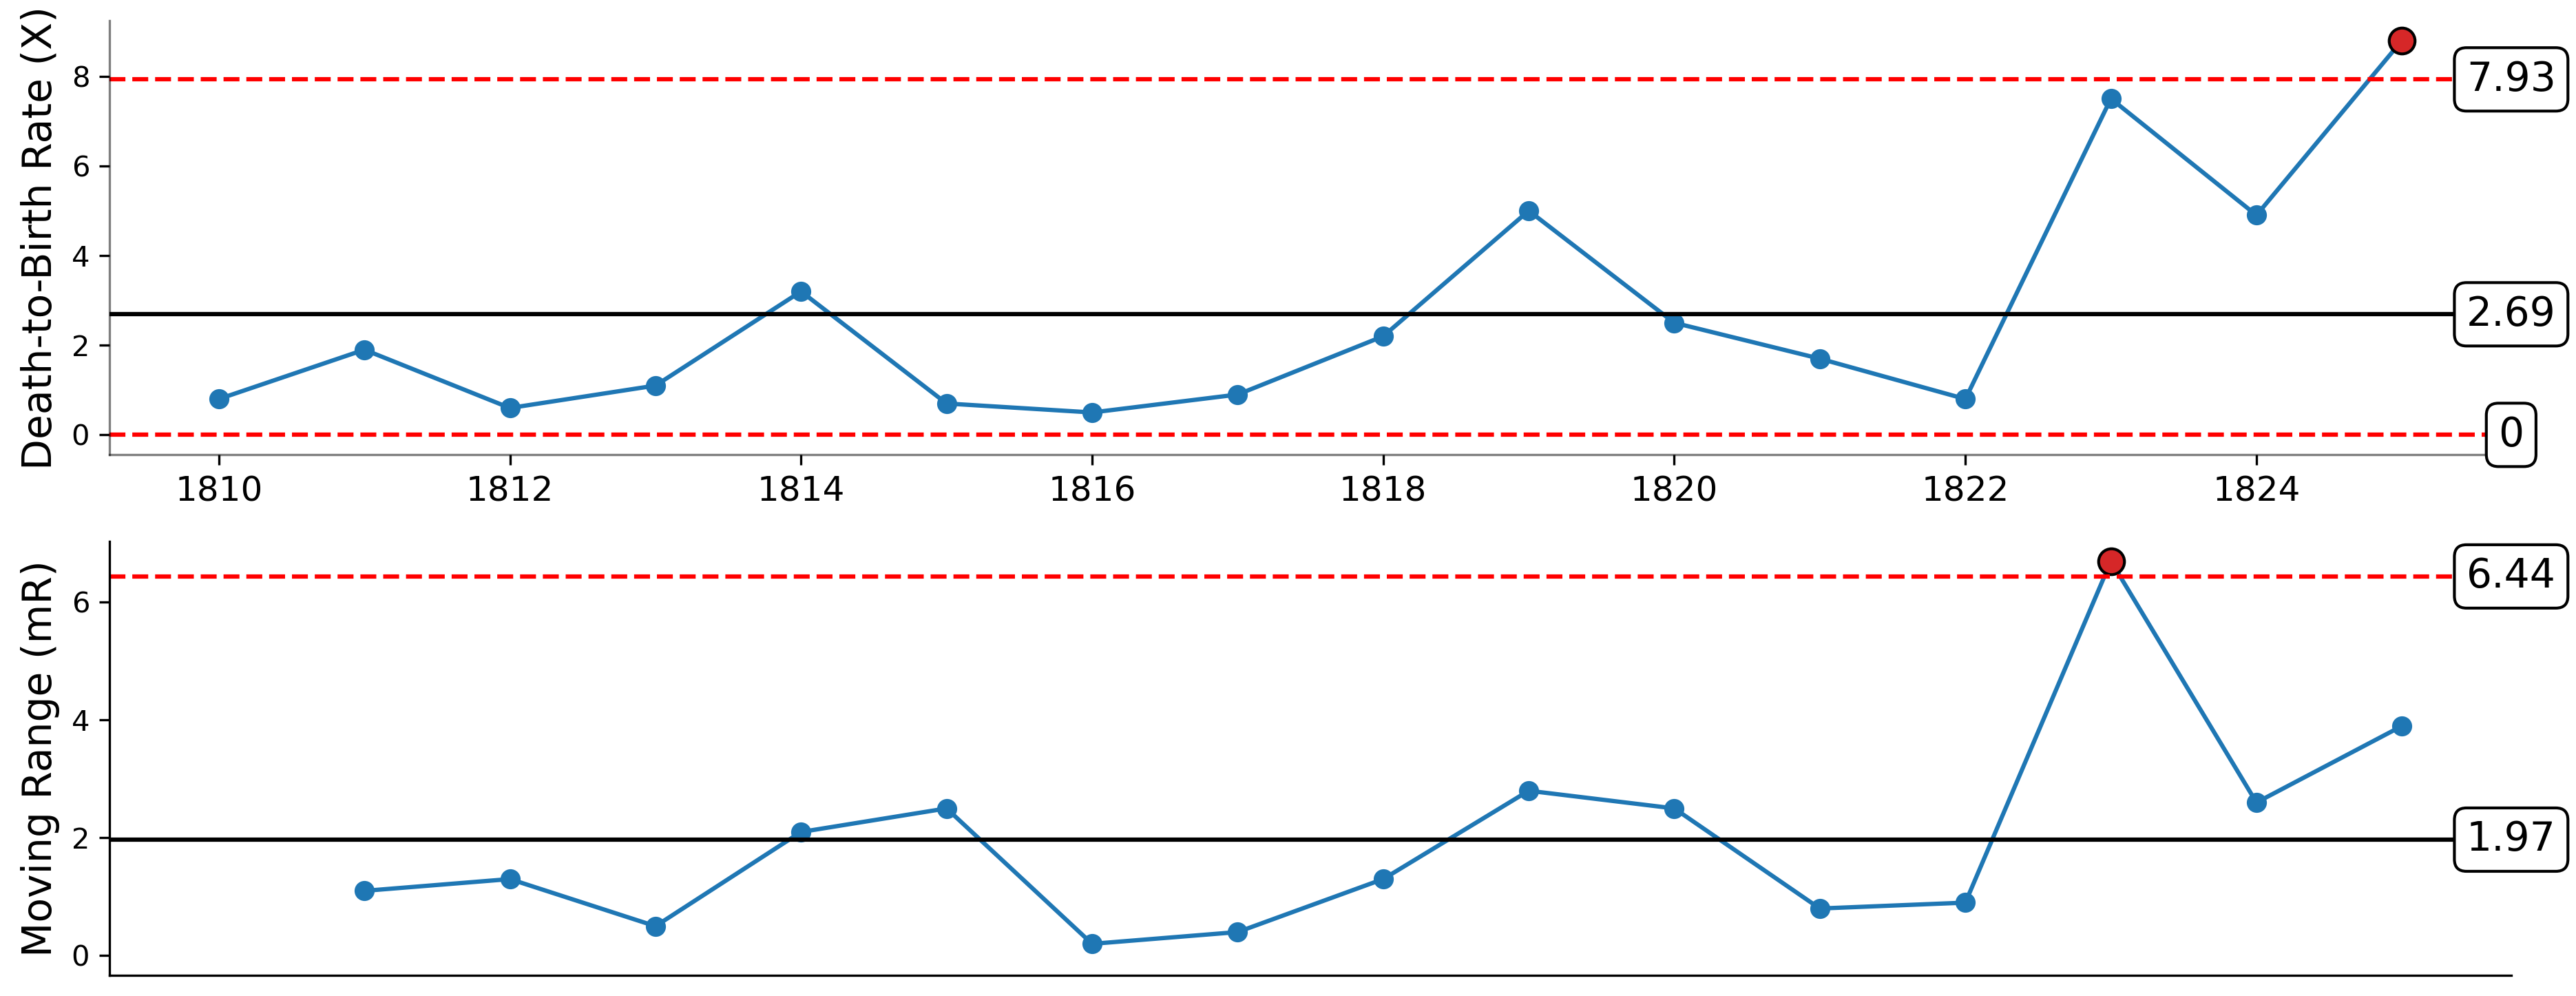

In [16]:
# --- Figure & Axes ---
fig, ax = plt.subplots(2, 1, figsize=(15, 6), dpi=300)

# --- Plot main data ---
ax[0].plot(labels, data, marker='o', label='X data')
ax[1].plot(labels, moving_range, marker='o', label='mR data')

# Create masking parameters for values beyond process limits
masked_values = {
    "upper_lim": np.ma.masked_where(data < stats['UPL'], data),
    "lower_lim": np.ma.masked_where(data >  stats['LPL'], data),
    "url_greater": np.ma.masked_where(moving_range <= stats['URL'], moving_range)
}

# Function to highlight points outside process limits
def highlight_assignable_causes(ax, labels, masked_values, color='tab:red', size=9):
    for key, masked_data in masked_values.items():
        ax.plot(labels, masked_data, marker='o', ls='none', color=color,
                markeredgecolor='black', markersize=size)

# Apply outlier highlighting
highlight_assignable_causes(ax[0], labels, {"upper_lim": masked_values["upper_lim"], "lower_lim": masked_values["lower_lim"]})
highlight_assignable_causes(ax[1], labels, {"url_greater": masked_values["url_greater"]})

# Offset moving ranges by plotting invisible x’s where values are NaN
for xi, yi in zip(labels, moving_range):
    if np.isnan(yi):
        ax[1].plot(xi, 0, marker='x', color='white', markersize=0)

# --- Add process limit & centerline lines ---
for value, linestyle, color in xchart_lines:
    ax[0].axhline(value, ls=linestyle, color=color)
for value, linestyle, color in mrchart_lines:
    ax[1].axhline(value, ls=linestyle, color=color)

# --- Add text labels for limits & centerlines ---
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
for y_val, label in xchart_labels:
    ax[0].text(
        ax[0].get_xlim()[1], y_val, label,
        ha='center', va='center', fontsize=14, bbox=bbox_props
    )
for y_val, label in mrchart_labels:
    ax[1].text(
        ax[1].get_xlim()[1], y_val, label,
        ha='center', va='center', fontsize=14, bbox=bbox_props
    )

# --- Aesthetics ---
sns.despine()
ax[0].spines[['left', 'bottom']].set_alpha(0.5)

# --- X-axis formatting ---
tick_interval = tickinterval
tick_positions = np.arange(0, len(labels), tick_interval)
ax[0].set_xticks(tick_positions)
ax[0].set_xticklabels(labels.iloc[tick_positions], fontsize=12)
ax[1].set_xticks([])  # remove ticks from lower chart

# --- Labels ---
ax[0].set_ylabel("Death-to-Birth Rate (X)", fontsize=14)
ax[1].set_ylabel("Moving Range (mR)", fontsize=14)

# plt.tight_layout()
plt.show()